# Phonon Interactions in Quantum Wires

:::{abstract}
This example demonstrates how to calculate phonon interactions in quantum wire systems using the `pulsesuite.PSTD3D.phonons` module. We investigate longitudinal optical (LO) phonon scattering, many-body phonon-carrier interactions, and temperature-dependent effects.
:::

## Theory

The phonons module calculates carrier-phonon interactions in quantum wires, which are essential for energy relaxation and dephasing in the Semiconductor Bloch Equations.

### Frohlich Interaction

Carriers interact with LO phonons through the Frohlich interaction, which couples carriers to the longitudinal optical phonon mode. The interaction strength depends on the dielectric properties of the material.

### Phonon Absorption and Emission

Carriers can absorb or emit phonons, leading to energy changes:

**Phonon Absorption:**
$
\Gamma_{abs}(k, k') \propto N_0 \cdot \delta(E_k - E_{k'} - \hbar\omega_{ph})
$

**Phonon Emission:**
$
\Gamma_{em}(k, k') \propto (N_0 + 1) \cdot \delta(E_k - E_{k'} + \hbar\omega_{ph})
$

where $N_0$ is the Bose-Einstein distribution for phonons at thermal equilibrium.

### Phonon Interaction Matrix

The phonon interaction matrix elements are calculated using Lorentzian line shapes:

$$
EP(k, k') = \frac{N_0}{(E_k - E_{k'} - \hbar\omega_{ph})^2 + (\hbar\gamma_{ph})^2} + \frac{N_0 + 1}{(E_k - E_{k'} + \hbar\omega_{ph})^2 + (\hbar\gamma_{ph})^2}
$$

where $\omega_{ph}$ is the phonon frequency and $\gamma_{ph}$ is the phonon damping rate.

### Many-Body Phonon Scattering

The many-body phonon scattering rates account for Pauli blocking and carrier-carrier interactions:

$$
W_{in}(k) = \sum_{k'} V_{ep}(k, k') \cdot n_e(k') \cdot EP^T(k', k)
$$

$$
W_{out}(k) = \sum_{k'} V_{ep}(k, k') \cdot (1 - n_e(k')) \cdot EP(k', k)
$$

where $V_{ep}$ is the screened electron-phonon interaction potential.

### Temperature Dependence

The phonon occupation follows the Bose-Einstein distribution:

$$
N_0 = \frac{1}{\exp(\hbar\omega_{ph} / k_B T) - 1}
$$

At low temperatures, phonon emission dominates (spontaneous emission). At high temperatures, both absorption and emission are significant.

## Setup and Initialization

First, we import the necessary modules and set up the physical parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pulsesuite.PSTD3D.phonons as phonons
from scipy.constants import e as e0, hbar, k as kB

# Physical Parameters for GaAs Quantum Wire
L = 200e-9              # Wire length (m)
N_k = 64                # Momentum grid points
m_e = 0.067 * 9.109e-31 # Electron effective mass (kg)
m_h = 0.45 * 9.109e-31  # Hole effective mass (kg)
epsr = 12.0             # Relative dielectric constant
Temp = 77.0             # Temperature (K)

# LO Phonon Parameters (GaAs)
Oph_eV = 0.036          # LO phonon energy (eV) - typical for GaAs
Oph = Oph_eV * e0 / hbar  # Convert to frequency (Hz)
Gph_eV = 0.003          # Phonon damping rate (eV)
Gph = Gph_eV * e0 / hbar  # Convert to frequency (Hz)

# Create momentum grid
ky = np.linspace(-2e8, 2e8, N_k)
dk = ky[1] - ky[0]

# Single-particle energies
E_e = hbar**2 * ky**2 / (2 * m_e)
E_h = hbar**2 * ky**2 / (2 * m_h)

print(f"Momentum grid: {ky.min():.2e} to {ky.max():.2e} m^-1")
print(f"LO Phonon energy: {Oph_eV*1e3:.1f} meV")
print(f"Phonon frequency: {Oph:.2e} Hz")
print(f"Temperature: {Temp} K")

Momentum grid: -2.00e+08 to 2.00e+08 m^-1
LO Phonon energy: 36.0 meV
Phonon frequency: 5.47e+13 Hz
Temperature: 77.0 K


## Initialize Phonon Module

We initialize the phonon module, which sets up the phonon interaction matrices.

In [2]:
# Initialize Phonon Module
phonons.InitializePhonons(ky, E_e, E_h, L, epsr, Gph, Oph)

print("Phonon module initialized")
print(f"Bose distribution N0: {phonons.N00():.4f}")
print(f"Vscale factor: {phonons._Vscale:.2e}")

Phonon module initialized
Bose distribution N0: 0.0044
Vscale factor: 1.52e-21


:::{note}
The `InitializePhonons` function sets up:
- `_NO`: Bose-Einstein distribution for phonons at thermal equilibrium
- `_idel`: Identity exclusion matrix (excludes self-interactions)
- `_EP`, `_EPT`: Electron-phonon interaction matrix and its transpose
- `_HP`, `_HPT`: Hole-phonon interaction matrix and its transpose
- `_Vscale`: Scaling constant for phonon coupling
:::

## Phonon Interaction Matrices

We examine the phonon interaction matrices, which describe the strength of phonon-mediated transitions.

EP shape: (64, 64)
HP shape: (64, 64)
EP range: 0.00e+00 to 1.93e+54
HP range: 0.00e+00 to 3.34e+53


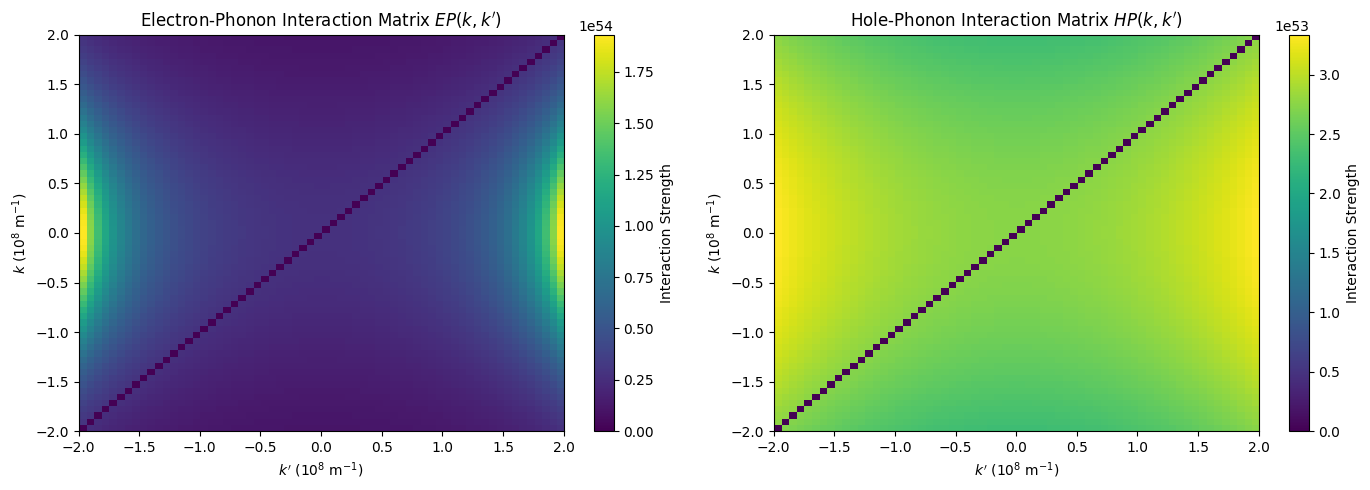

In [3]:
# Access the phonon interaction matrices (stored as module-level variables)
EP = phonons._EP
HP = phonons._HP

print(f"EP shape: {EP.shape}")
print(f"HP shape: {HP.shape}")
print(f"EP range: {EP.min():.2e} to {EP.max():.2e}")
print(f"HP range: {HP.min():.2e} to {HP.max():.2e}")

# Visualize phonon interaction matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Electron-phonon interaction
im1 = axes[0].imshow(EP, aspect='auto', origin='lower',
                     extent=[ky.min()/1e8, ky.max()/1e8, ky.min()/1e8, ky.max()/1e8])
axes[0].set_xlabel('$k\'$ ($10^8$ m$^{-1}$)')
axes[0].set_ylabel('$k$ ($10^8$ m$^{-1}$)')
axes[0].set_title('Electron-Phonon Interaction Matrix $EP(k,k\')$')
plt.colorbar(im1, ax=axes[0], label='Interaction Strength')

# Hole-phonon interaction
im2 = axes[1].imshow(HP, aspect='auto', origin='lower',
                     extent=[ky.min()/1e8, ky.max()/1e8, ky.min()/1e8, ky.max()/1e8])
axes[1].set_xlabel('$k\'$ ($10^8$ m$^{-1}$)')
axes[1].set_ylabel('$k$ ($10^8$ m$^{-1}$)')
axes[1].set_title('Hole-Phonon Interaction Matrix $HP(k,k\')$')
plt.colorbar(im2, ax=axes[1], label='Interaction Strength')

plt.tight_layout()
plt.show()

:::{note}
The phonon interaction matrices show strong interactions when the energy difference $E_k - E_{k'}$ matches the phonon energy $\hbar\omega_{ph}$. The diagonal is zero due to the `_idel` matrix, which excludes self-interactions.
:::

## Energy Dependence of Phonon Interactions

Let's examine how the phonon interaction strength depends on energy difference.

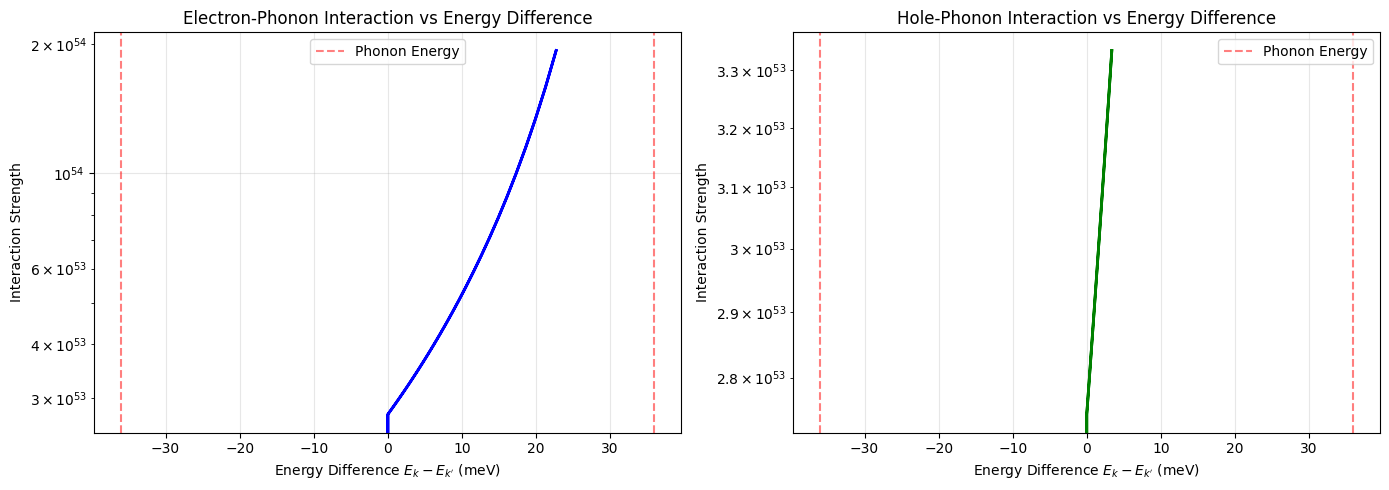

In [4]:
# Extract interaction strength along a cut through the matrix
# Look at transitions from k=0 (center of grid)
k_center = N_k // 2
EP_cut = EP[k_center, :]
HP_cut = HP[k_center, :]

# Energy differences
dE_e = E_e - E_e[k_center]
dE_h = E_h - E_h[k_center]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(dE_e/e0*1e3, EP_cut, 'b-', linewidth=2)
ax.axvline(Oph_eV*1e3, color='r', linestyle='--', alpha=0.5, label='Phonon Energy')
ax.axvline(-Oph_eV*1e3, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Energy Difference $E_k - E_{k\'}$ (meV)')
ax.set_ylabel('Interaction Strength')
ax.set_title('Electron-Phonon Interaction vs Energy Difference')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
ax.plot(dE_h/e0*1e3, HP_cut, 'g-', linewidth=2)
ax.axvline(Oph_eV*1e3, color='r', linestyle='--', alpha=0.5, label='Phonon Energy')
ax.axvline(-Oph_eV*1e3, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Energy Difference $E_k - E_{k\'}$ (meV)')
ax.set_ylabel('Interaction Strength')
ax.set_title('Hole-Phonon Interaction vs Energy Difference')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

:::{tip}
The interaction strength peaks when the energy difference equals the phonon energy (absorption) or negative phonon energy (emission). The width of the peaks is determined by the phonon damping rate $\gamma_{ph}$.
:::

## Many-Body Phonon Scattering

We calculate the many-body phonon scattering rates for electrons and holes.

In [5]:
# Create carrier distributions
sigma_k = 1e8
n_e = np.exp(-ky**2 / (2 * sigma_k**2))
n_h = np.exp(-ky**2 / (2 * sigma_k**2))
n_e /= np.sum(n_e)  # Normalize
n_h /= np.sum(n_h)  # Normalize

# Create Coulomb interaction arrays (simplified for this demo)
# In real simulations, these would come from the coulomb module
VC = np.zeros((N_k, N_k, 3))
VC[:, :, 1] = np.eye(N_k) * 1e-20  # Electron-electron (simplified)
VC[:, :, 2] = np.eye(N_k) * 1e-20  # Hole-hole (simplified)

# Dielectric function (simplified - unity for this demo)
E1D = np.ones((N_k, N_k))

# Calculate phonon-electron scattering rates
Win_e = np.zeros(N_k)
Wout_e = np.zeros(N_k)
phonons.MBPE(n_e, VC, E1D, Win_e, Wout_e)

# Calculate phonon-hole scattering rates
Win_h = np.zeros(N_k)
Wout_h = np.zeros(N_k)
phonons.MBPH(n_h, VC, E1D, Win_h, Wout_h)

print(f"Electron in-scattering rate range: {Win_e.min():.2e} to {Win_e.max():.2e} s^-1")
print(f"Electron out-scattering rate range: {Wout_e.min():.2e} to {Wout_e.max():.2e} s^-1")
print(f"Hole in-scattering rate range: {Win_h.min():.2e} to {Win_h.max():.2e} s^-1")
print(f"Hole out-scattering rate range: {Wout_h.min():.2e} to {Wout_h.max():.2e} s^-1")

Electron in-scattering rate range: 0.00e+00 to 0.00e+00 s^-1
Electron out-scattering rate range: 0.00e+00 to 0.00e+00 s^-1
Hole in-scattering rate range: 0.00e+00 to 0.00e+00 s^-1
Hole out-scattering rate range: 0.00e+00 to 0.00e+00 s^-1


## Visualization of Scattering Rates

We visualize the phonon scattering rates as a function of momentum.

/tmp/ipykernel_389758/2617775316.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/tmp/ipykernel_389758/2617775316.py:19: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


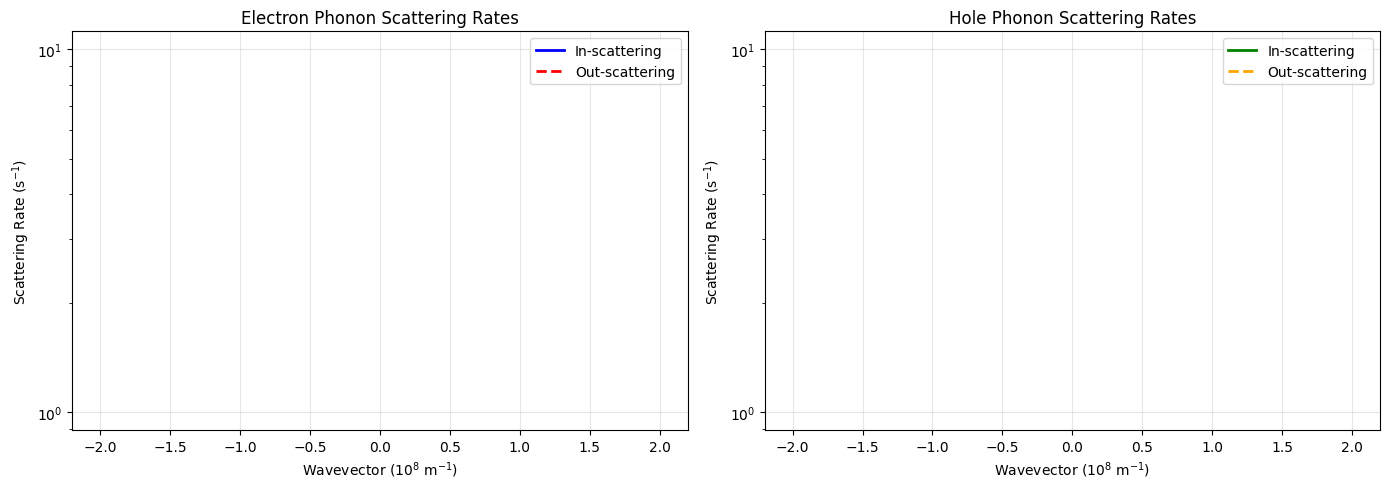

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(ky/1e8, Win_e, 'b-', label='In-scattering', linewidth=2)
ax.plot(ky/1e8, Wout_e, 'r--', label='Out-scattering', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Scattering Rate (s$^{-1}$)')
ax.set_title('Electron Phonon Scattering Rates')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
ax.plot(ky/1e8, Win_h, 'g-', label='In-scattering', linewidth=2)
ax.plot(ky/1e8, Wout_h, 'orange', linestyle='--', label='Out-scattering', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Scattering Rate (s$^{-1}$)')
ax.set_title('Hole Phonon Scattering Rates')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

:::{note}
The scattering rates show how carriers at different momenta scatter due to phonon interactions. In-scattering populates states, while out-scattering depopulates them. The rates depend on the carrier distribution and phonon occupation.
:::

## Phonon Coupling Constants

The phonon coupling constant `Cq2` is used in the DC field module for phonon-assisted transport.

Cq2 range: 0.00e+00 to 1.52e-41


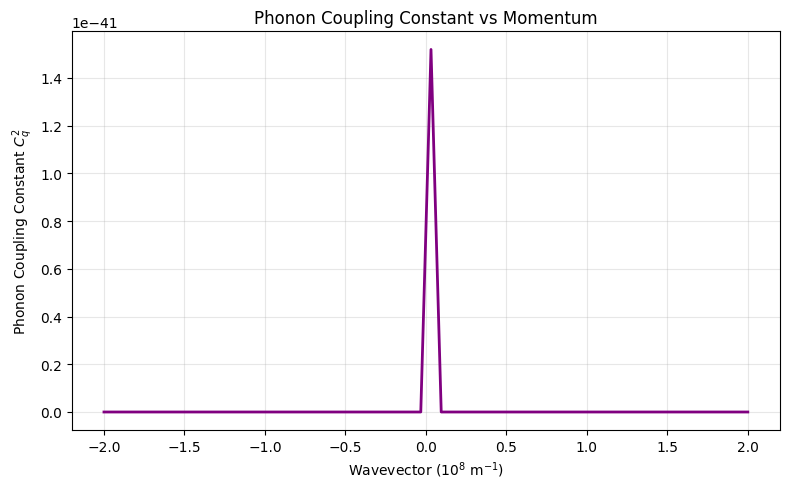

In [7]:
# Calculate phonon coupling constants
# This requires interaction potential V and dielectric function E1D
# For this demo, we'll use simplified arrays
V_test = np.eye(N_k) * 1e-20  # Simplified interaction potential
E1D_test = np.ones((N_k, N_k))  # Simplified dielectric function

Cq2_vals = phonons.Cq2(ky, V_test, E1D_test)

print(f"Cq2 range: {Cq2_vals.min():.2e} to {Cq2_vals.max():.2e}")

# Visualize coupling constant
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ky/1e8, Cq2_vals, 'purple', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Phonon Coupling Constant $C_q^2$')
ax.set_title('Phonon Coupling Constant vs Momentum')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Distribution Functions

The module provides Fermi-Dirac and Bose-Einstein distribution functions.

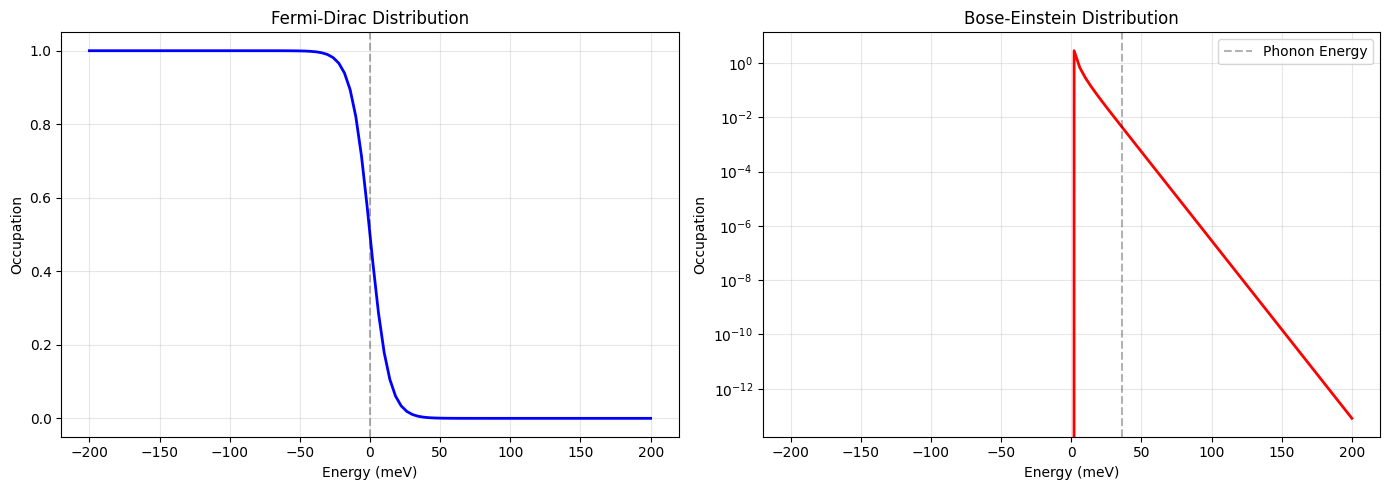

Bose distribution at phonon energy: 0.0044


In [8]:
# Calculate distribution functions for a range of energies
E_range = np.linspace(-0.2*e0, 0.2*e0, 100)

# Fermi-Dirac distribution (for carriers)
f_FD = phonons.FermiDistr(E_range)

# Bose-Einstein distribution (for phonons)
f_BE = phonons.BoseDistr(E_range)

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(E_range/e0*1e3, f_FD, 'b-', linewidth=2)
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('Occupation')
ax.set_title('Fermi-Dirac Distribution')
ax.grid(True, alpha=0.3)
ax.axvline(0, color='k', linestyle='--', alpha=0.3)

ax = axes[1]
ax.plot(E_range/e0*1e3, f_BE, 'r-', linewidth=2)
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('Occupation')
ax.set_title('Bose-Einstein Distribution')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.axvline(Oph_eV*1e3, color='k', linestyle='--', alpha=0.3, label='Phonon Energy')
ax.legend()

plt.tight_layout()
plt.show()

# Get the Bose distribution value for phonons
N0_phonon = phonons.N00()
print(f"Bose distribution at phonon energy: {N0_phonon:.4f}")

## Temperature Dependence

We investigate how phonon interactions change with temperature.

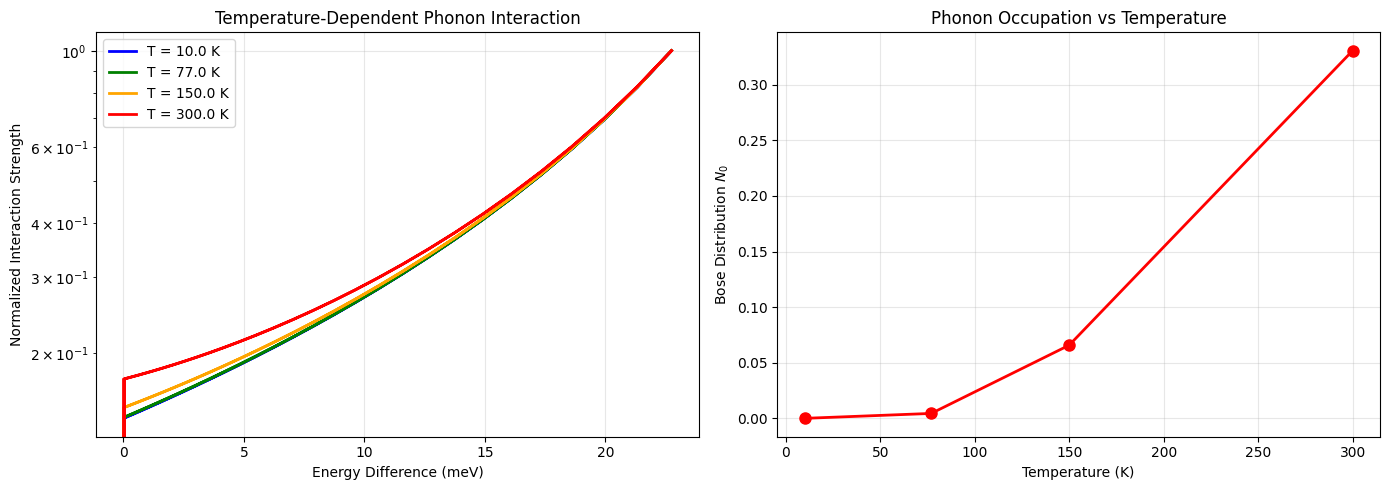

In [9]:
# Calculate phonon interaction matrices at different temperatures
temperatures = [10.0, 77.0, 150.0, 300.0]
colors = ['blue', 'green', 'orange', 'red']

# Store Bose distribution values
N0_values = []

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for T, color in zip(temperatures, colors):
    # Update temperature
    phonons._Temp = T

    # Re-initialize to update temperature-dependent arrays
    phonons.InitializePhonons(ky, E_e, E_h, L, epsr, Gph, Oph)

    N0 = phonons.N00()
    N0_values.append(N0)

    # Extract interaction strength along diagonal cut
    k_center = N_k // 2
    EP_cut = phonons._EP[k_center, :]
    dE = E_e - E_e[k_center]

    # Normalize for comparison
    EP_cut_norm = EP_cut / np.max(EP_cut) if np.max(EP_cut) > 0 else EP_cut

    axes[0].plot(dE/e0*1e3, EP_cut_norm, color=color, linewidth=2, label=f'T = {T} K')

axes[0].set_xlabel('Energy Difference (meV)')
axes[0].set_ylabel('Normalized Interaction Strength')
axes[0].set_title('Temperature-Dependent Phonon Interaction')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot Bose distribution vs temperature
axes[1].plot(temperatures, N0_values, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Temperature (K)')
axes[1].set_ylabel('Bose Distribution $N_0$')
axes[1].set_title('Phonon Occupation vs Temperature')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

:::{tip}
At higher temperatures, the Bose distribution increases, leading to more phonon absorption processes. The phonon interaction strength also changes with temperature through the $N_0$ and $N_0 + 1$ factors in the interaction matrix.
:::

## Scattering Rate Temperature Dependence

We examine how scattering rates depend on temperature.

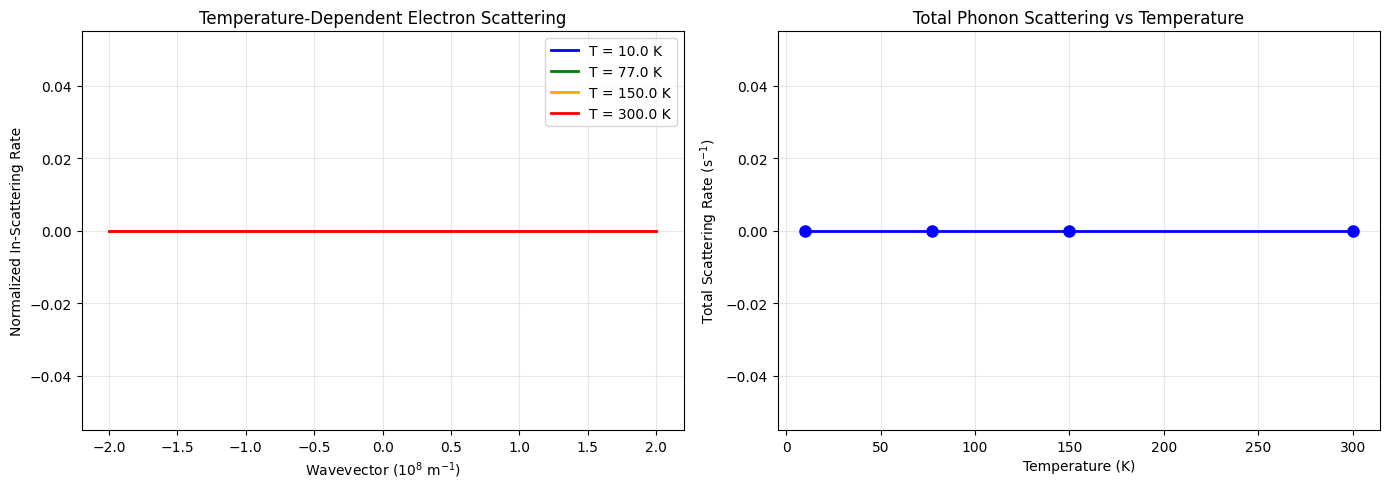

In [10]:
# Calculate scattering rates at different temperatures
temperatures = [10.0, 77.0, 150.0, 300.0]
colors = ['blue', 'green', 'orange', 'red']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for T, color in zip(temperatures, colors):
    # Update temperature and re-initialize
    phonons._Temp = T
    phonons.InitializePhonons(ky, E_e, E_h, L, epsr, Gph, Oph)

    # Recalculate scattering rates
    Win_e_T = np.zeros(N_k)
    Wout_e_T = np.zeros(N_k)
    phonons.MBPE(n_e, VC, E1D, Win_e_T, Wout_e_T)

    # Normalize for comparison
    Win_e_T_norm = Win_e_T / np.max(Win_e_T) if np.max(Win_e_T) > 0 else Win_e_T

    axes[0].plot(ky/1e8, Win_e_T_norm, color=color, linewidth=2, label=f'T = {T} K')

axes[0].set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
axes[0].set_ylabel('Normalized In-Scattering Rate')
axes[0].set_title('Temperature-Dependent Electron Scattering')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot total scattering rate vs temperature
total_scattering = []
for T in temperatures:
    phonons._Temp = T
    phonons.InitializePhonons(ky, E_e, E_h, L, epsr, Gph, Oph)
    Win_e_T = np.zeros(N_k)
    Wout_e_T = np.zeros(N_k)
    phonons.MBPE(n_e, VC, E1D, Win_e_T, Wout_e_T)
    total_scattering.append(np.sum(Win_e_T + Wout_e_T))

axes[1].plot(temperatures, total_scattering, 'bo-', linewidth=2, markersize=8)
axes[1].set_xlabel('Temperature (K)')
axes[1].set_ylabel('Total Scattering Rate (s$^{-1}$)')
axes[1].set_title('Total Phonon Scattering vs Temperature')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Assumptions and Parameter Choices

This section explains the assumptions and rationale behind the parameter values chosen for this example.

### Material Parameters

**Host material (AlAs):**
- `epsr0 = 10.0`: Static dielectric constant
- `epsrINF = 8.2`: High-frequency dielectric constant
- **Rationale**: Typical values for AlAs host material. The difference determines the Frohlich coupling strength.

**Quantum wire (GaAs):**
- `epsr = 12.0`: Background dielectric constant
- **Rationale**: GaAs value. Used for screening calculations.

**LO Phonon parameters:**
- `Oph = 36 meV`: LO phonon energy for GaAs
- `Gph = 3 meV`: Phonon damping rate
- **Rationale**: Typical GaAs LO phonon values. The 36 meV energy corresponds to the longitudinal optical phonon mode in GaAs.

### Temperature

**Default temperature:**
- `Temp = 77.0 K`: Liquid nitrogen temperature
- **Rationale**: Common experimental condition. Low enough to reduce thermal phonon population while remaining accessible.

**Temperature range for studies:**
- `[10.0, 77.0, 150.0, 300.0] K`
- **Rationale**: Covers cryogenic (10 K), liquid nitrogen (77 K), intermediate (150 K), and room temperature (300 K) to show thermal effects.

### Grid and Numerical Parameters

**Momentum grid:**
- `N_k = 64`: Number of momentum points
- `k_range = [-2e8, 2e8] m^-1`: Momentum range
- **Rationale**: 64 points balances resolution and speed. Range covers relevant k-space for phonon-assisted transitions.

### Simplifications

**Coulomb interaction arrays:**
- Simplified to diagonal matrices with constant values
- **Rationale**: For demonstration. Realistic calculations should use the `coulomb` module to compute screened Coulomb interactions.

**Dielectric function:**
- Set to unity (no screening)
- **Rationale**: Simplifies the example. Full simulations would include frequency-dependent screening.

**Carrier distributions:**
- Gaussian distributions centered at k=0
- **Rationale**: Simple, symmetric distribution representing photoexcited carriers. Realistic distributions would come from SBE evolution.

**Static distributions:**
- Carrier densities do not evolve in time
- **Rationale**: Demonstrates the phonon calculation interface. Full simulations would evolve carriers via SBEs.

### Phonon Model

**Single phonon mode:**
- Only LO phonons are considered
- **Rationale**: LO phonons dominate carrier-phonon interactions in polar semiconductors like GaAs. Other modes (acoustic, TO) are typically weaker.

**Lorentzian line shape:**
- Phonon transitions use Lorentzian broadening
- **Rationale**: Accounts for phonon lifetime and dephasing. The width is determined by the damping rate $\gamma_{ph}$.

:::{warning}
**Important Limitations:**
1. **Carrier evolution**: Distributions are static. Full simulations require coupling with the SBE solver.
2. **Coulomb interactions**: Simplified diagonal matrices. Use the `coulomb` module for realistic calculations.
3. **Screening**: Uses unity dielectric function. Full simulations include frequency-dependent screening.
4. **Phonon modes**: Only LO phonons considered. Other modes may be important in some materials.
5. **Material parameters**: Bulk GaAs values. Confined systems may need adjusted parameters.
:::

## Summary

This example demonstrated:

1. **Initialization** of the phonon module with physical parameters
2. **Phonon interaction matrices** (`EP`, `HP`) describing absorption and emission processes
3. **Many-body phonon scattering** (`MBPE`, `MBPH`) for electrons and holes
4. **Phonon coupling constants** (`Cq2`) for use in DC field transport
5. **Distribution functions** (`FermiDistr`, `BoseDistr`) for carriers and phonons
6. **Temperature dependence** of phonon interactions and scattering rates

The `phonons` module provides a comprehensive framework for calculating phonon-carrier interactions in quantum wires, including many-body effects, temperature dependence, and coupling to other modules like DC field transport.